In [141]:
import io
from google.colab import files
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from math import isnan
import seaborn as sn
import datetime
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from google.colab import drive
%matplotlib inline
import requests
import networkx as nx

In [126]:
drive.flush_and_unmount()

In [127]:
drive.mount('/content/drive')

Mounted at /content/drive


# Inspect Data

In [128]:
with open('/content/drive/MyDrive/PredictionModel/bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv', 'r') as f:
  hist = pd.read_csv(f)

In [4]:
hist.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
hist.tail(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4727767,1609372260,28836.97,28849.67,28807.78,28826.52,2.051917,59173.965272,28838.376450
4727768,1609372320,28826.49,28844.25,28816.09,28816.09,0.721410,20803.457100,28837.207539
4727769,1609372380,28814.36,28822.71,28800.00,28800.00,1.529671,44076.572351,28814.411945
4727770,1609372440,28800.00,28832.79,28800.00,28831.35,2.036450,58675.679644,28812.732950
4727771,1609372500,28809.07,28825.50,28800.01,28810.08,0.087391,2517.799582,28810.597267
4727772,1609372560,28801.47,28829.42,28785.64,28829.42,0.965221,27804.572129,28806.429798
4727773,1609372620,28829.42,28863.90,28829.42,28857.06,2.368831,68332.350629,28846.441863
4727774,1609372680,28850.49,28900.52,28850.49,28882.82,2.466590,71232.784464,28879.056266
4727775,1609372740,28910.54,28911.52,28867.60,28881.30,7.332773,211870.912660,28893.695831
4727776,1609372800,28893.21,28928.49,28893.21,28928.49,5.757679,166449.709320,28909.166061


In [113]:
def get_updated_data(): 
  market = 'BTCUSDT'
  tick_interval = '1m'

  url = 'https://api.binance.com/api/v1/klines?symbol='+market+'&interval='+tick_interval+'&limit=2000'
  data = requests.get(url).json()
  return data


In [114]:
data = get_updated_data()
live_data = pd.DataFrame(data, columns=["Timestamp","Open","High","Low","Close","Volume_(BTC)","CloseTime","Volume_(Currency)","NumberOfTrades","TakerBuyBaseAssetVolume","TakerBuyQuoteAssetVolume","Unknown"])

finalTimeStamp=int(str(live_data.iloc[29]['Timestamp'])[0:10])
initialTimeStamp=int(str(live_data.iloc[28]['Timestamp'])[0:10])

live_data=live_data.drop(["CloseTime","NumberOfTrades","TakerBuyBaseAssetVolume","TakerBuyQuoteAssetVolume","Unknown"], axis=1)

live_data["Weighted_Price"]=live_data["Open"]
hist=live_data

In [115]:
hist.shape

(1000, 8)

In [129]:
hist_copy = hist.copy()
hist.shape

(4727777, 8)

In [130]:
hist["Close"].max()

28997.38

In [131]:
hist["Open"].max()

28997.38

In [132]:
hist = hist.set_index(['Timestamp'])
hist.index = pd.to_datetime(hist.index, unit='s')

In [ ]:
hist.isnull().sum()

In [69]:
def replace_NaN(df):
  old_df = df.copy()
  for row_index, row in old_df.iterrows():
     column_index = 0
     for value in row:
       if isnan(value):
         df.iloc[row_index, column_index] = df.iloc[row_index-1, column_index] 
       column_index += 1

In [70]:
def replace_NaN_with_median(data):
  data['Open'] = data['Open'].fillna(data['Open'].median())
  data['High'] = data['High'].fillna(data['High'].median())
  data['Low'] = data['Low'].fillna(data['Low'].median())
  data['Close'] = data['Close'].fillna(data['Close'].median())
  data['Volume_(BTC)'] = data['Volume_(BTC)'].fillna(data['Volume_(BTC)'].median())
  data['Volume_(Currency)'] = data['Volume_(Currency)'].fillna(data['Volume_(Currency)'].median())
  data['Weighted_Price'] = data['Weighted_Price'].fillna(data['Weighted_Price'].median())


In [133]:
hist =  hist.dropna(axis = 0, how = 'any')

In [134]:
hist.isnull().sum() #Should be zero

Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [170]:
#i will create a graph where each edge represents a change of one minute from one price to another one.
#If an edge already exists the weight increases
G = nx.Graph()   # or DiGraph, MultiGraph, MultiDiGraph, etc


In [162]:
(1,5) in G.edges()

False

In [174]:
prev = hist['Close'][0]
for current in (list(hist['Close'][1:])):
  if (prev,current) in G.edges():
    G[prev][current]['weight']+=1
  else:
    G.add_weighted_edges_from([(prev, current, 1.0)])
  prev = current

In [168]:
G.edges()

EdgeView([(0, 1), (1, 2), (4.39, 4.39), (4.39, 4.57), (4.57, 4.58), (4.58, 4.58)])

{(0, 1): Text(0.8110642809699906, -0.42672996469558355, '3.0'),
 (1, 2): Text(0.7425803543421101, -0.33055980686998376, '200'),
 (4.39, 4.39): Text(-1.0, 0.24843831971764407, '1.0'),
 (4.39, 4.57): Text(-0.8999810847379555, 0.3287656197657035, '1.0'),
 (4.57, 4.58): Text(-0.6780054255712455, 0.4590152665476914, '1.0'),
 (4.58, 4.58): Text(-0.5560486816665803, 0.5089376132816199, '1.0')}

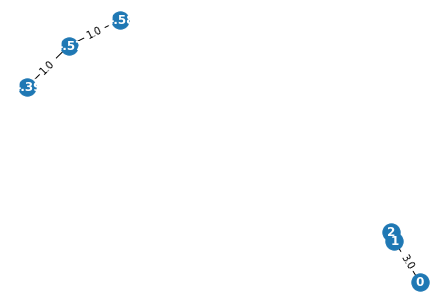

In [167]:
my_pos = nx.spring_layout(G, seed = 1000)
nx.draw(G,pos=my_pos, with_labels=True,font_color='white',font_weight='bold')
edge_labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, my_pos, edge_labels = edge_labels)

In [73]:
hist_copy.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
995,1613180220000,47646.45000000,47662.74000000,47626.99000000,47632.84000000,38.48398700,1833465.13850789,47646.45000000
996,1613180280000,47632.83000000,47665.88000000,47622.21000000,47641.05000000,41.92303200,1997458.67928988,47632.83000000
997,1613180340000,47641.05000000,47659.99000000,47615.98000000,47647.49000000,25.64081400,1221539.71699620,47641.05000000
998,1613180400000,47647.49000000,47656.78000000,47624.00000000,47650.00000000,23.36616000,1113296.93940790,47647.49000000
999,1613180460000,47649.99000000,47652.80000000,47623.31000000,47629.86000000,29.63653100,1411802.85610762,47649.99000000


# Train-Test split

In [74]:
def train_test_split(array, test_size=0.2):
    split_row = len(array) - int(test_size * len(array))
    train_data = array[:split_row]
    test_data = array[split_row:]
    return train_data, test_data
    
train, test = train_test_split(hist, test_size=0.2)

In [75]:
target_col = 'Close'
target_index = 3
hist.iloc[1:5, target_index]

Timestamp
1613120580000    47135.94000000
1613120640000    47134.44000000
1613120700000    47147.40000000
1613120760000    47130.89000000
Name: Close, dtype: object

In [76]:
def line_plot(line1, line2, label1=None, label2=None, title='Train-Test split', lw=2):
    fig, ax = plt.subplots(1, figsize=(16, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Close Price', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)




In [77]:
#line_plot(train[target_col], test[target_col], 'training', 'Train-Test split', title='')

In [78]:
plot_cols = ['Open', 'High', 'Close']
plot_features = hist[plot_cols]


In [79]:
#_ = plot_features.plot(subplots=True)

In [80]:
plot_cols = ['Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price']
plot_features = hist[plot_cols]


In [81]:
#_ = plot_features.plot(subplots=True)

# Normalization

In [82]:
#scaler = StandardScaler()
#hist_array = scaler.fit_transform(hist)
#hist = pd.DataFrame(hist_array, columns=hist_copy.columns.drop('Timestamp'))

In [83]:
target = hist[target_col].to_numpy()
target = target.reshape(-1,1)
scaler = MinMaxScaler(feature_range = (0,1))

scaler2 = MinMaxScaler(feature_range = (0,1))
scaler2.fit(target)

hist_array = scaler.fit_transform(hist)
hist = pd.DataFrame(hist_array, columns=hist_copy.columns.drop("Timestamp"))

In [84]:
target.shape

(1000, 1)

In [85]:
hist.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
995,0.737111,0.714896,0.772716,0.730874,0.038557,0.039329,0.737111
996,0.729839,0.716733,0.770257,0.735264,0.042984,0.043855,0.729839
997,0.734228,0.713287,0.767052,0.738708,0.022025,0.022443,0.734228
998,0.737667,0.711409,0.771178,0.740050,0.019097,0.019457,0.737667
999,0.739002,0.709080,0.770823,0.729281,0.027168,0.027694,0.739002


In [86]:
hist.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
995,0.737111,0.714896,0.772716,0.730874,0.038557,0.039329,0.737111
996,0.729839,0.716733,0.770257,0.735264,0.042984,0.043855,0.729839
997,0.734228,0.713287,0.767052,0.738708,0.022025,0.022443,0.734228
998,0.737667,0.711409,0.771178,0.740050,0.019097,0.019457,0.737667
999,0.739002,0.709080,0.770823,0.729281,0.027168,0.027694,0.739002


In [87]:
hist.shape

(1000, 7)

# Data Windowing

In [88]:
def extract_window_data(array, window_len=30):
  X = []
  y  = []
  for i in range(window_len, len(array)-window_len):
      X.append(array[i-window_len:i])
      y.append(array[i:i+ int(window_len/3), target_index])
  X, y = np.array(X), np.array(y)
  return X, y

In [89]:
def prepare_data(array, target_col, window_len=30, test_size=0.2):
    #We split the dataset into train and test
    train_data, test_data = train_test_split(array, test_size=test_size)
    #We extract all the possible windows
    X_train, y_train = extract_window_data(train_data, window_len)
    #We extract all the possible windows
    X_test, y_test = extract_window_data(test_data, window_len)
   
    return X_train, y_train, X_test, y_test

# LSTM Model

In [90]:
def build_lstm_model(window_len, num_features, output_size, neurons=50, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape =(window_len, num_features)))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    
    return model

**Parameters**

In [91]:
np.random.seed(42)
window_len = 30
test_size = 0.2
lstm_neurons = 100
epochs = 2
num_features = len(hist.columns)
activ_func = 'linear'
batch_size = 256
loss = 'mape'
dropout = 0.2
output_size = 10
optimizer = keras.optimizers.Adam(learning_rate=0.00003)

In [92]:
hist_array.shape

(1000, 7)

In [93]:
X_train, y_train, X_test, y_test = prepare_data(hist_array, target_col, window_len=window_len, test_size=test_size)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
model = build_lstm_model(window_len, num_features, output_size=output_size, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
model.summary()

In [ ]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs=epochs, verbose=1, shuffle=True)

In [ ]:
history.history

In [ ]:
results = model.evaluate(X_test, y_test)

In [ ]:
preds = model.predict(X_test)

In [ ]:
preds.shape

In [ ]:
predictions = scaler2.inverse_transform(preds)
real_values = scaler2.inverse_transform(y_test)

In [ ]:
def plot(real_values, predictions,  plot_col='Close', max_subplots=5, print_step  = 100000):
  plt.figure(figsize=(12, 8))
  x = []
  for i in range(10):
    x.append(i+1) 
  for n in range(max_subplots):
    plt.subplot(max_subplots, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.scatter(x, real_values[print_step * n], edgecolors='k', label='Labels', c='#2ca02c', s=64)
    plt.scatter(x, predictions[print_step * n], marker='X', edgecolors='k', label='Predictions',c='#ff7f0e', s=64)

  plt.xlabel('Time [10min]')


In [ ]:
# Visualizing the results
plt.plot(real_values, color = 'red', label = 'Real')
plt.plot(predictions, color = 'blue', label = 'Predicted')
plt.title('Bitcoin Close Price min')
plt.ylabel('Close price')
plt.show()

In [ ]:
 plot(real_values, predictions,  plot_col='Close', max_subplots=6, print_step = 100000)

In [ ]:
 plot(real_values, predictions,  plot_col='Close', max_subplots=2, print_step = 690000)

In [43]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save("/content/drive/My Drive/MachineLearningProject/nn_for_bitcoin_price_20min.h5")

NameError: ignored




# Convolutional model

In [116]:
np.random.seed(42)
window_len = 30
test_size = 0.05
epochs = 5
num_features = len(hist.columns)
batch_size = 128
loss = 'mape'
dropout = 0.2
output_size = 10
optimizer = keras.optimizers.Adam(learning_rate=0.00001)

In [117]:
def build_conv_model(output_size, neurons=512, loss='mape', optimizer='adam'):
    CONV_WIDTH = 3
    model = Sequential()
    model.add(tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]))
    model.add(tf.keras.layers.Conv1D(neurons, activation='relu', kernel_size=(CONV_WIDTH)))
    model.add(tf.keras.layers.Dense(output_size, kernel_initializer=tf.initializers.zeros()))
    model.add(tf.keras.layers.Reshape([output_size]))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mape'])
    return model

In [118]:
model = build_conv_model(output_size=output_size, loss=loss, optimizer=optimizer)

In [119]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs=epochs, verbose=1, shuffle=True)

Epoch 1/5
6/6 [==============================] - 1s 4ms/step - loss: 308.0252 - mape: 308.0252
Epoch 2/5
6/6 [==============================] - 0s 4ms/step - loss: 570.1570 - mape: 570.1570
Epoch 3/5
6/6 [==============================] - 0s 3ms/step - loss: 396.7830 - mape: 396.7830
Epoch 4/5
6/6 [==============================] - 0s 4ms/step - loss: 499.3583 - mape: 499.3583
Epoch 5/5
6/6 [==============================] - 0s 2ms/step - loss: 203.1842 - mape: 203.1842


In [120]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save("/content/drive/My Drive/PredictionModel/last_7_days_cnn_for_bitcoin_price_10min.h5")

In [121]:
results = model.evaluate(X_test, y_test)
print("test loss:", results)

5/5 [==============================] - 0s 3ms/step - loss: 99.9093 - mape: 99.9093
test loss: [99.90926361083984, 99.90926361083984]


In [122]:
preds = model.predict(X_test)

In [74]:
y_test.shape

(696800, 10)

In [123]:
predictions = scaler2.inverse_transform(preds)
real_values = scaler2.inverse_transform(y_test)

In [ ]:
predictions.shape

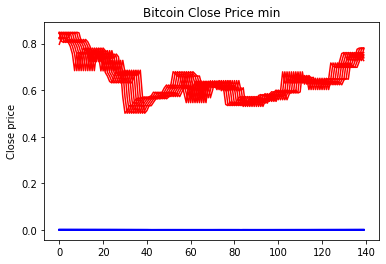

In [124]:
# Visualizing the results
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(preds, color = 'blue', label = 'Predicted')
plt.title('Bitcoin Close Price min')
plt.ylabel('Close price')
plt.show()

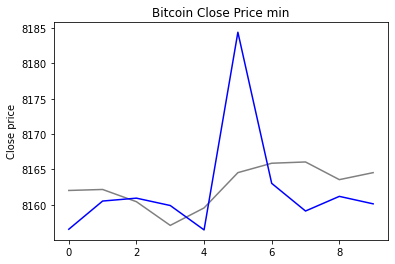

In [51]:
# Visualizing the results
plt.plot(real_values[70000], color = 'grey', label = 'Real')
plt.plot(predictions[70000], color = 'blue', label = 'Predicted')
plt.title('Bitcoin Close Price min')
plt.ylabel('Close price')
plt.show()

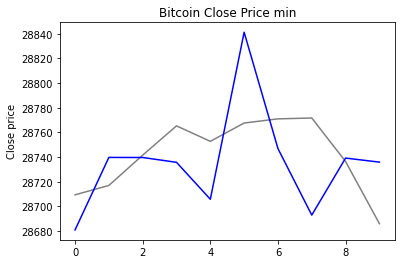

In [55]:
# Visualizing the results
plt.plot(real_values[-30], color = 'grey', label = 'Real')
plt.plot(predictions[-30], color = 'blue', label = 'Predicted')
plt.title('Bitcoin Close Price min')
plt.ylabel('Close price')
plt.show()

In [ ]:
 plot(real_values, predictions,  plot_col='Close', max_subplots=6, print_step = 100000)

In [ ]:
 plot(real_values, predictions,  plot_col='Close', max_subplots=2, print_step = 690000)

In [ ]:
 plot(real_values, predictions,  plot_col='Close', max_subplots=5, print_step = 50000)

In [ ]:
 plot(real_values, predictions,  plot_col='Close', max_subplots=3, print_step = 120000)